5•EuclideanDistance: given two points, returns the Euclidean distance of the two.
•GreatCircleDistance: given two points, returns the great circle distance of the two.
Note, that the addPoints function will be used to compute the new cluster centers. As we are working with spatial data given as latitude-longitude pairs implementing this function in a meaningful way will need some thought!The used distance measure (Euclidean or great circle), as well as the parameter k(number of clusters) should be read as an input from the command line.
Select a suitable convergence criterion and create a variableconvergeDistthat will be used to decide when the k-means calculation is done, i.e. when the amount the locations of the means change between iterations is less than convergeDist. A "perfect" solution would be 0, which is not achievable due to numeric computations. Hence, convergeDist is a param- eter that represents a "good enough" solution. Select a small value for it that makes sense for your dataset and convergence criterion.
Parse  the  input  file,  which  should  be  specified  as  a  S3  address,  into  (latitude,longitude)  pairs.  
Be  sure  to  persist  (cache)  the  resulting  RDD  because  you  will  access  it  each  time  through the following iterations.
Now, plan and implement the main part of the k-means algorithm. Make sure to consider an efficient implementation being aware of tasks, stages, and cached RDDs.
When the iteration is complete, display and return the final k center points and store the kclusters (i.e., all data points plus cluster information).

Step 3: Compute and Visualize ClustersIn this step, you will compare the clusters using Euclidean distance vs. great circle distance. 
Calculate the k-means clusters for the device location data using k = 5. 
Calculate the k-means clusters for the synthetic location data using k = 2 and k = 4. 
Calculate the k-means clusters for the large-scale DBpedia location data. 
You will need to experiment with the number of clusters (maybe use k = 6 for a start or k = 2 or 4 if you use the US locations only). 
Argue, what choice of k makes sense by considering the problem context, i.e., what could the clusters actuallymean/represent? Visualize the clusters and cluster centers (use a random subset of data points for the last dataset) for both distance measures. Can you observe a difference?

## K-means - Device Location

In [2]:
inputbucket="s3://6007.finalproject/parsed_data/"

In [3]:
data = sc.textFile(inputbucket)

In [4]:
%time
print(data.take(1))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs
["Row(latitude=33.689476013183594, longtitude=-117.54330444335938, date='2014-03-15 10:10:20', manufacturer='Sorrento', model_name='F41L')"]


In [5]:
import re
%time
replacement=""
pattern="[A-Za-z\(]+="
data = data.map(lambda x: ( re.sub(pattern,replacement,x).replace(')','') )  )\
.map(lambda x: x.replace("'","").split(", "))\
.map(lambda x: ( float(x[0]), float(x[1]), x[2] , x[3], x[4]  ))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs


In [6]:
data.cache()

PythonRDD[3] at RDD at PythonRDD.scala:53

In [7]:
from pyspark.sql import types
df = spark.createDataFrame(data, schema=types.StructType([\
                                                        types.StructField('latitude', types.FloatType(),True),
                                                        types.StructField('longitude', types.FloatType(),True),
                                                        types.StructField('date', types.StringType(),True),
                                                        types.StructField('manufacturer', types.StringType(),True),
                                                          types.StructField('model', types.StringType(),True)

]))

In [8]:
df.cache()

DataFrame[latitude: float, longitude: float, date: string, manufacturer: string, model: string]

In [64]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import time
start_time = time.time()

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
X = vecAssembler.transform(df)

# Model
kmeans = KMeans().setK(5).setSeed(1)
model = kmeans.fit(X)

predictions = model.transform(X)

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)
print("--- %s seconds ---" % (time.time() - start_time))

Silhouette with squared euclidean distance = 0.7779851895575357
Cluster Centers: 
[  38.02864791 -121.23352192]
[  34.29718423 -117.78653245]
[  43.98989868 -122.77665336]
[  34.58818551 -112.35533553]
[  42.25924472 -116.90267328]
--- 4.3069422245025635 seconds ---


## We are going to manually calculate the euclidean and great circle distances below.

In [65]:
predictions = predictions.rdd.map(lambda x: (x[0],x[1],x[6],float(centers[x[6]][0]),float(centers[x[6]][1])))
predictions_df = spark.createDataFrame(predictions, schema=types.StructType([\
                                                        types.StructField('original_latitude', types.FloatType(),True),
                                                        types.StructField('original_longitude', types.FloatType(),True),
                                                        types.StructField('prediction', types.IntegerType(),True),
                                                        types.StructField('center_latitude', types.FloatType(),True),
                                                        types.StructField('center_longitude', types.FloatType(),True)

]))

In [67]:
predictions_df.show(3)

+-----------------+------------------+----------+---------------+----------------+
|original_latitude|original_longitude|prediction|center_latitude|center_longitude|
+-----------------+------------------+----------+---------------+----------------+
|        33.689476|       -117.543304|         1|      34.297184|      -117.78653|
|         37.43211|        -121.48503|         0|       38.02865|      -121.23352|
|         39.43789|        -120.93898|         0|       38.02865|      -121.23352|
+-----------------+------------------+----------+---------------+----------------+
only showing top 3 rows



In [119]:
import pyspark.sql.functions as F
predictions_df_with_gcd = predictions_df.withColumn("a", (\
    F.pow(F.sin(F.radians(F.col("center_latitude") - F.col("original_latitude")) / 2), 2) +\
    F.cos(F.radians(F.col("original_latitude"))) * F.cos(F.radians(F.col("center_latitude"))) *\
    F.pow(F.sin(F.radians(F.col("center_longitude") - F.col("original_longitude")) / 2), 2)\
)).withColumn("gc_dist", F.atan2(F.sqrt(F.col("a")), F.sqrt(-F.col("a") + 1)) * 12742000)\
.drop(F.col("prediction")).drop(F.col("a"))\
.withColumn("eu_dist", F.pow( (F.col('center_latitude') - F.col('original_latitude')  ),2 )+\
                    F.pow( (F.col('center_longitude') - F.col('original_longitude')  ),2 ) )

In [120]:
predictions_df_with_gcd.show(3)

+-----------------+------------------+---------------+----------------+-----------------+-------------------+
|original_latitude|original_longitude|center_latitude|center_longitude|          gc_dist|            eu_dist|
+-----------------+------------------+---------------+----------------+-----------------+-------------------+
|        33.689476|       -117.543304|      34.297184|      -117.78653|71197.25683187979|0.42846743379777763|
|         37.43211|        -121.48503|       38.02865|      -121.23352|69922.61967336302|0.41911582615284715|
|         39.43789|        -120.93898|       38.02865|      -121.23352|158769.1391050153| 2.0727134647313505|
+-----------------+------------------+---------------+----------------+-----------------+-------------------+
only showing top 3 rows



In [122]:
predictions_df_with_gcd.cache()

DataFrame[original_latitude: float, original_longitude: float, center_latitude: float, center_longitude: float, gc_dist: double, eu_dist: double]

In [121]:
predictions_df_with_gcd.registerTempTable("predictions_df_with_gcd")

In [124]:
sqlContext.sql("select SUM(gc_dist)/COUNT(gc_dist),SUM(eu_dist)/COUNT(eu_dist) from predictions_df_with_gcd").show(10)

+-----------------------------------------------+-----------------------------------------------+
|(sum(gc_dist) / CAST(count(gc_dist) AS DOUBLE))|(sum(eu_dist) / CAST(count(eu_dist) AS DOUBLE))|
+-----------------------------------------------+-----------------------------------------------+
|                              132700.5067084632|                              2.536413567676747|
+-----------------------------------------------+-----------------------------------------------+



## K-Means Synthetic Location

In [125]:
inputbucket="s3://6007.finalproject/sample_geo.txt"

In [126]:
data2 = sc.textFile(inputbucket)\
.flatMap(lambda x: x.split("\n"))\
.filter(lambda x: (x!="") and ("L" not in x) )\
.map(lambda x: x.split("\t"))\
.map(lambda x: (float(x[0]),float(x[1])))

In [283]:
data2.take(1)

[(37.77253945, -77.49954987)]

In [3]:
data2.cache()

PythonRDD[2] at RDD at PythonRDD.scala:53

In [131]:
df2 = spark.createDataFrame(data2, schema=types.StructType([\
                                                        types.StructField('latitude', types.FloatType(),True),
                                                        types.StructField('longitude', types.FloatType(),True)

]))

In [ ]:
df2.cache()

In [145]:
start_time = time.time()

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
X2 = vecAssembler.transform(df2)

# Model
kmeans2 = KMeans().setK(2).setSeed(1)
model2 = kmeans2.fit(X2)

kmeans4 = KMeans().setK(4).setSeed(1)
model4 = kmeans4.fit(X2)

predictions2 = model2.transform(X2)
predictions4 = model4.transform(X2)

# Shows the result.
centers2 = model2.clusterCenters()
centers4 = model4.clusterCenters()
print("Cluster Centers K=2: ")
for center in centers2:
    print(center)
print("Cluster Centers K=4: ")
for center in centers4:
    print(center)
print("--- %s seconds ---" % (time.time() - start_time))

Cluster Centers K=2: 
[ 37.56474721 -82.55711082]
[  38.07161548 -116.43342043]
Cluster Centers K=4: 
[ 40.14836238 -76.96598964]
[  35.57495006 -113.07189577]
[  41.49405837 -121.33793417]
[ 35.11449777 -87.93102449]
--- 2.810687780380249 seconds ---


In [152]:
predictions2_rdd = predictions2.rdd.map(lambda x: (x[0],x[1],x[3],float(centers2[x[3]][0]),float(centers2[x[3]][1])))
df = spark.createDataFrame(predictions2_rdd, schema=types.StructType([\
                                                        types.StructField('original_latitude', types.FloatType(),True),
                                                        types.StructField('original_longitude', types.FloatType(),True),
                                                        types.StructField('prediction', types.IntegerType(),True),
                                                        types.StructField('center_latitude', types.FloatType(),True),
                                                        types.StructField('center_longitude', types.FloatType(),True)
]))

In [173]:
import pyspark.sql.functions as F
df = df.withColumn("a", (\
    F.pow(F.sin(F.radians(F.col("center_latitude") - F.col("original_latitude")) / 2), 2) +\
    F.cos(F.radians(F.col("original_latitude"))) * F.cos(F.radians(F.col("center_latitude"))) *\
    F.pow(F.sin(F.radians(F.col("center_longitude") - F.col("original_longitude")) / 2), 2)\
)).withColumn("gc_dist", F.atan2(F.sqrt(F.col("a")), F.sqrt(-F.col("a") + 1)) * 12742000)\
.drop(F.col("prediction")).drop(F.col("a"))\
.withColumn("eu_dist", F.pow( (F.col('center_latitude') - F.col('original_latitude')  ),2 )+\
                    F.pow( (F.col('center_longitude') - F.col('original_longitude')  ),2 ) )

In [174]:
df.show(3)

+-----------------+------------------+---------------+----------------+------------------+------------------+
|original_latitude|original_longitude|center_latitude|center_longitude|           gc_dist|           eu_dist|
+-----------------+------------------+---------------+----------------+------------------+------------------+
|         37.77254|         -77.49955|      37.564747|       -82.55711|445697.46533880796|25.622129831521306|
|        42.090134|        -87.689156|      37.564747|       -82.55711| 667018.4268019216|46.816980165967834|
|         39.56342|         -75.58753|      37.564747|       -82.55711| 645216.0229611602|52.569759438571054|
+-----------------+------------------+---------------+----------------+------------------+------------------+
only showing top 3 rows



In [175]:
df.registerTempTable("df")
sqlContext.sql("select SUM(gc_dist)/COUNT(gc_dist),SUM(eu_dist)/COUNT(eu_dist) from df").show(10)

+-----------------------------------------------+-----------------------------------------------+
|(sum(gc_dist) / CAST(count(gc_dist) AS DOUBLE))|(sum(eu_dist) / CAST(count(eu_dist) AS DOUBLE))|
+-----------------------------------------------+-----------------------------------------------+
|                              730104.5231404818|                              70.63638292632837|
+-----------------------------------------------+-----------------------------------------------+



In [183]:
predictions4.show(2)

+---------+----------+--------------------+----------+
| latitude| longitude|            features|prediction|
+---------+----------+--------------------+----------+
| 37.77254| -77.49955|[37.7725410461425...|         0|
|42.090134|-87.689156|[42.0901336669921...|         3|
+---------+----------+--------------------+----------+
only showing top 2 rows



In [184]:
predictions4_rdd = predictions4.rdd.map(lambda x: (x[0],x[1],x[3],float(centers4[x[3]][0]),float(centers4[x[3]][1])))
df = spark.createDataFrame(predictions4_rdd, schema=types.StructType([\
                                                        types.StructField('original_latitude', types.FloatType(),True),
                                                        types.StructField('original_longitude', types.FloatType(),True),
                                                        types.StructField('prediction', types.IntegerType(),True),
                                                        types.StructField('center_latitude', types.FloatType(),True),
                                                        types.StructField('center_longitude', types.FloatType(),True)
]))

In [186]:
import pyspark.sql.functions as F
df = df.withColumn("a", (\
    F.pow(F.sin(F.radians(F.col("center_latitude") - F.col("original_latitude")) / 2), 2) +\
    F.cos(F.radians(F.col("original_latitude"))) * F.cos(F.radians(F.col("center_latitude"))) *\
    F.pow(F.sin(F.radians(F.col("center_longitude") - F.col("original_longitude")) / 2), 2)\
)).withColumn("gc_dist", F.atan2(F.sqrt(F.col("a")), F.sqrt(-F.col("a") + 1)) * 12742000)\
.drop(F.col("prediction")).drop(F.col("a"))\
.withColumn("eu_dist", F.pow( (F.col('center_latitude') - F.col('original_latitude')  ),2 )+\
                    F.pow( (F.col('center_longitude') - F.col('original_longitude')  ),2 ) )

In [187]:
df.registerTempTable("df2")
sqlContext.sql("select SUM(gc_dist)/COUNT(gc_dist),SUM(eu_dist)/COUNT(eu_dist) from df2").show(10)

+-----------------------------------------------+-----------------------------------------------+
|(sum(gc_dist) / CAST(count(gc_dist) AS DOUBLE))|(sum(eu_dist) / CAST(count(eu_dist) AS DOUBLE))|
+-----------------------------------------------+-----------------------------------------------+
|                              532013.1570450937|                             36.665836915395765|
+-----------------------------------------------+-----------------------------------------------+



## K-Means DBpedia Location

In [1]:
inputbucket="s3://6007.finalproject/lat_longs.txt"

In [2]:
import re

data = sc.textFile(inputbucket)\
.map(lambda x: x.split(" "))

In [3]:
import re
pattern="[^\d.-]+[.]{1}[^\d.]+"
repl=""
data = sc.textFile(inputbucket)\
.map(lambda x: x.split(" "))\
.map(lambda x: (re.sub(pattern,repl,x[0]),x[1],x[2]))\
.filter(lambda x: x[0]!="")\
.map(lambda x:(float(x[0]),float(x[1]), x[2] ))

In [4]:
data.cache()

PythonRDD[4] at RDD at PythonRDD.scala:53

In [5]:
from pyspark.sql import types
df = spark.createDataFrame(data, schema=types.StructType([\
                                                        types.StructField('latitude', types.FloatType(),True),
                                                        types.StructField('longitude', types.FloatType(),True),
                                                        types.StructField('Site', types.StringType(),True)

]))

In [6]:
df.show(3)

+---------+---------+--------------------+
| latitude|longitude|                Site|
+---------+---------+--------------------+
|     36.7|3.2166667|<http://dbpedia.o...|
|     42.5|1.5166667|<http://dbpedia.o...|
|12.516666|-70.03333|<http://dbpedia.o...|
+---------+---------+--------------------+
only showing top 3 rows



In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import time
start_time = time.time()

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
X3 = vecAssembler.transform(df)

# Model
kmeans2 = KMeans().setK(2).setSeed(1)
model2 = kmeans2.fit(X3)

kmeans4 = KMeans().setK(4).setSeed(1)
model4 = kmeans4.fit(X3)

kmeans6 = KMeans().setK(6).setSeed(1)
model6 = kmeans6.fit(X3)

predictions2 = model2.transform(X3)
predictions4 = model4.transform(X3)
predictions6 = model6.transform(X3)

predictions2.cache()
predictions4.cache()
predictions6.cache()

# Shows the result.
centers2 = model2.clusterCenters()
centers4 = model4.clusterCenters()
centers6 = model6.clusterCenters()
print("Cluster Centers K=2: ")
for center in centers2:
    print(center)
print("Cluster Centers K=4: ")
for center in centers4:
    print(center)
print("Cluster Centers K=6: ")
for center in centers4:
    print(center)
print("--- %s seconds ---" % (time.time() - start_time))

Cluster Centers K=2: 
[40.18205687 32.48327172]
[ 35.94167287 -88.83209608]
Cluster Centers K=4: 
[48.43652453  9.99936844]
[ 35.93470852 -88.9150858 ]
[ 18.51080852 123.643959  ]
[28.35921384 56.72666129]
Cluster Centers K=6: 
[48.43652453  9.99936844]
[ 35.93470852 -88.9150858 ]
[ 18.51080852 123.643959  ]
[28.35921384 56.72666129]
--- 31.543789625167847 seconds ---


In [43]:
predictions2_rdd = predictions2.rdd.map(lambda x: (x[0],x[1],x[4],float(centers2[x[4]][0]),float(centers2[x[4]][1])))
df1 = spark.createDataFrame(predictions2_rdd, schema=types.StructType([\
                                                        types.StructField('original_latitude', types.FloatType(),True),
                                                        types.StructField('original_longitude', types.FloatType(),True),
                                                        types.StructField('prediction', types.IntegerType(),True),
                                                        types.StructField('center_latitude', types.FloatType(),True),
                                                        types.StructField('center_longitude', types.FloatType(),True)
]))

import pyspark.sql.functions as F
df1 = df1.withColumn("a", (\
    F.pow(F.sin(F.radians(F.col("center_latitude") - F.col("original_latitude")) / 2), 2) +\
    F.cos(F.radians(F.col("original_latitude"))) * F.cos(F.radians(F.col("center_latitude"))) *\
    F.pow(F.sin(F.radians(F.col("center_longitude") - F.col("original_longitude")) / 2), 2)\
)).withColumn("gc_dist", F.atan2(F.sqrt(F.col("a")), F.sqrt(-F.col("a") + 1)) * 12742000)\
.drop(F.col("a"))\
.withColumn("eu_dist", F.pow( (F.col('center_latitude') - F.col('original_latitude')  ),2 )+\
                    F.pow( (F.col('center_longitude') - F.col('original_longitude')  ),2 ) )

In [44]:
df1.drop(F.col('prediction')).show(3)

+-----------------+------------------+---------------+----------------+------------------+-----------------+
|original_latitude|original_longitude|center_latitude|center_longitude|           gc_dist|          eu_dist|
+-----------------+------------------+---------------+----------------+------------------+-----------------+
|             36.7|         3.2166667|      40.182056|       32.483273|2566289.6920982013|868.6589019522216|
|             42.5|         1.5166667|      40.182056|       32.483273|2583587.1626723097|964.3035582459561|
|        12.516666|         -70.03333|      35.941673|       -88.83209| 3214123.721362224|902.1243039452966|
+-----------------+------------------+---------------+----------------+------------------+-----------------+
only showing top 3 rows



In [16]:
df1.registerTempTable("df_latlong1")
sqlContext.sql("select SUM(gc_dist)/COUNT(gc_dist),SUM(eu_dist)/COUNT(eu_dist) from df_latlong1").show(10)

+-----------------------------------------------+-----------------------------------------------+
|(sum(gc_dist) / CAST(count(gc_dist) AS DOUBLE))|(sum(eu_dist) / CAST(count(eu_dist) AS DOUBLE))|
+-----------------------------------------------+-----------------------------------------------+
|                             2526786.4716782477|                             1242.8234952762402|
+-----------------------------------------------+-----------------------------------------------+



In [40]:
predictions4_rdd = predictions4.rdd.map(lambda x: (x[0],x[1],x[4],float(centers4[x[4]][0]),float(centers4[x[4]][1])))
df2 = spark.createDataFrame(predictions4_rdd, schema=types.StructType([\
                                                        types.StructField('original_latitude', types.FloatType(),True),
                                                        types.StructField('original_longitude', types.FloatType(),True),
                                                        types.StructField('prediction', types.IntegerType(),True),
                                                        types.StructField('center_latitude', types.FloatType(),True),
                                                        types.StructField('center_longitude', types.FloatType(),True)
]))

import pyspark.sql.functions as F
df2 = df2.withColumn("a", (\
    F.pow(F.sin(F.radians(F.col("center_latitude") - F.col("original_latitude")) / 2), 2) +\
    F.cos(F.radians(F.col("original_latitude"))) * F.cos(F.radians(F.col("center_latitude"))) *\
    F.pow(F.sin(F.radians(F.col("center_longitude") - F.col("original_longitude")) / 2), 2)\
)).withColumn("gc_dist", F.atan2(F.sqrt(F.col("a")), F.sqrt(-F.col("a") + 1)) * 12742000)\
.drop(F.col("a"))\
.withColumn("eu_dist", F.pow( (F.col('center_latitude') - F.col('original_latitude')  ),2 )+\
                    F.pow( (F.col('center_longitude') - F.col('original_longitude')  ),2 ) )

In [42]:
df2.drop(F.col('prediction')).show(3)

+-----------------+------------------+---------------+----------------+------------------+------------------+
|original_latitude|original_longitude|center_latitude|center_longitude|           gc_dist|           eu_dist|
+-----------------+------------------+---------------+----------------+------------------+------------------+
|             36.7|         3.2166667|      48.436523|        9.999369|1416923.7066886013|183.75101049274076|
|             42.5|         1.5166667|      48.436523|        9.999369| 933439.1195545978|107.19854807519368|
|        12.516666|         -70.03333|      35.934708|      -88.915085| 3218406.521958237| 904.9252141390025|
+-----------------+------------------+---------------+----------------+------------------+------------------+
only showing top 3 rows



In [19]:
df2.registerTempTable("df_latlong2")
sqlContext.sql("select SUM(gc_dist)/COUNT(gc_dist),SUM(eu_dist)/COUNT(eu_dist) from df_latlong2").show(10)

+-----------------------------------------------+-----------------------------------------------+
|(sum(gc_dist) / CAST(count(gc_dist) AS DOUBLE))|(sum(eu_dist) / CAST(count(eu_dist) AS DOUBLE))|
+-----------------------------------------------+-----------------------------------------------+
|                             1431525.8149716915|                              385.8855322130194|
+-----------------------------------------------+-----------------------------------------------+



In [20]:
predictions6_rdd = predictions6.rdd.map(lambda x: (x[0],x[1],x[4],float(centers6[x[4]][0]),float(centers6[x[4]][1])))
df3 = spark.createDataFrame(predictions6_rdd, schema=types.StructType([\
                                                        types.StructField('original_latitude', types.FloatType(),True),
                                                        types.StructField('original_longitude', types.FloatType(),True),
                                                        types.StructField('prediction', types.IntegerType(),True),
                                                        types.StructField('center_latitude', types.FloatType(),True),
                                                        types.StructField('center_longitude', types.FloatType(),True)
]))

import pyspark.sql.functions as F
df3 = df3.withColumn("a", (\
    F.pow(F.sin(F.radians(F.col("center_latitude") - F.col("original_latitude")) / 2), 2) +\
    F.cos(F.radians(F.col("original_latitude"))) * F.cos(F.radians(F.col("center_latitude"))) *\
    F.pow(F.sin(F.radians(F.col("center_longitude") - F.col("original_longitude")) / 2), 2)\
)).withColumn("gc_dist", F.atan2(F.sqrt(F.col("a")), F.sqrt(-F.col("a") + 1)) * 12742000)\
.drop(F.col("a"))\
.withColumn("eu_dist", F.pow( (F.col('center_latitude') - F.col('original_latitude')  ),2 )+\
                    F.pow( (F.col('center_longitude') - F.col('original_longitude')  ),2 ) )

In [39]:
df3.drop(F.col('prediction')).show(3)

+-----------------+------------------+---------------+----------------+------------------+------------------+
|original_latitude|original_longitude|center_latitude|center_longitude|           gc_dist|           eu_dist|
+-----------------+------------------+---------------+----------------+------------------+------------------+
|             36.7|         3.2166667|       48.59884|          9.7733|1426288.6588699806|184.57178927056543|
|             42.5|         1.5166667|       48.59884|          9.7733| 933432.3362596794|105.36783580617339|
|        12.516666|         -70.03333|     -18.668272|      -63.107796| 3549762.674538302|1020.4634491852521|
+-----------------+------------------+---------------+----------------+------------------+------------------+
only showing top 3 rows



In [22]:
df3.cache()

DataFrame[original_latitude: float, original_longitude: float, prediction: int, center_latitude: float, center_longitude: float, gc_dist: double, eu_dist: double]

In [23]:
df3.registerTempTable("df_latlong3")
start_time = time.time()
sqlContext.sql("select SUM(gc_dist)/COUNT(gc_dist),SUM(eu_dist)/COUNT(eu_dist) from df_latlong3").show(10)
print("--- %s seconds ---" % (time.time() - start_time))

+-----------------------------------------------+-----------------------------------------------+
|(sum(gc_dist) / CAST(count(gc_dist) AS DOUBLE))|(sum(eu_dist) / CAST(count(eu_dist) AS DOUBLE))|
+-----------------------------------------------+-----------------------------------------------+
|                             1192528.1209456117|                             264.35301051973346|
+-----------------------------------------------+-----------------------------------------------+

--- 8.375382661819458 seconds ---


In [38]:
df3.drop(F.col('prediction')).show(3)

+-----------------+------------------+---------------+----------------+------------------+------------------+
|original_latitude|original_longitude|center_latitude|center_longitude|           gc_dist|           eu_dist|
+-----------------+------------------+---------------+----------------+------------------+------------------+
|             36.7|         3.2166667|       48.59884|          9.7733|1426288.6588699806|184.57178927056543|
|             42.5|         1.5166667|       48.59884|          9.7733| 933432.3362596794|105.36783580617339|
|        12.516666|         -70.03333|     -18.668272|      -63.107796| 3549762.674538302|1020.4634491852521|
+-----------------+------------------+---------------+----------------+------------------+------------------+
only showing top 3 rows



In [25]:
collected_data = df3.rdd.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6])).collect()

In [26]:
import numpy as np

collected_array = np.array(collected_data)
collected_array = collected_array.reshape(-1,7)

In [27]:
import pandas as pd
plot_df = pd.DataFrame(collected_array, columns=['original_lat','original_long','pred','center_lat','center_long','gcd','eud'])

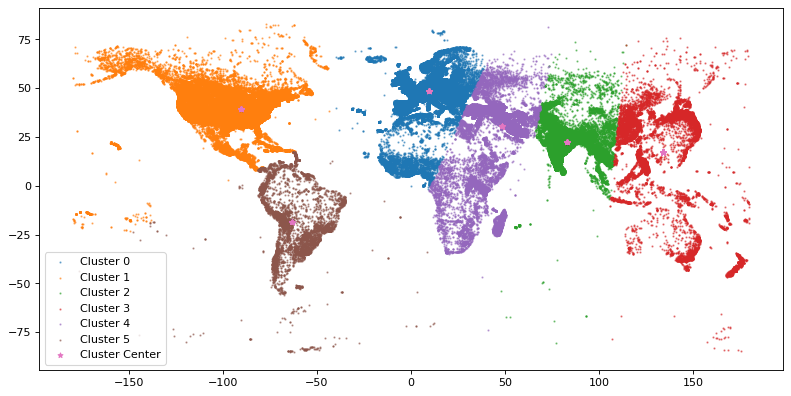

In [36]:
#colorful plot of the clusters and the cluster centers
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
for i in range(6):
    mask = plot_df.pred == i
    plt.scatter(plot_df.original_long[mask],plot_df.original_lat[mask],s=1,label="Cluster "+str(i),alpha=.5)
plt.scatter(plot_df.center_long,plot_df.center_lat,label="Cluster Center",s=20,marker="*")
plt.legend()

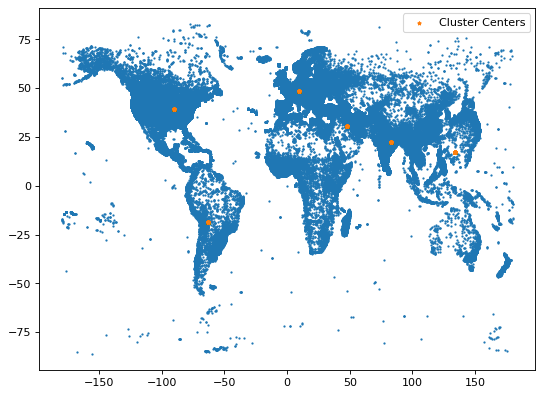

In [34]:
#not as colorful version
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(collected_array[:,1],collected_array[:,0],s=1)
plt.scatter(collected_array[:,4],collected_array[:,3],label="Cluster Centers",s=10,marker="*")
plt.legend()

In [144]:
us_data = all_data[(all_data.Longtitude > lowest_us_long)&(all_data.Longtitude < highest_us_long)\
                  &(all_data.Latitude > lowest_us_lat)&(all_data.Latitude < highest_us_lat)]

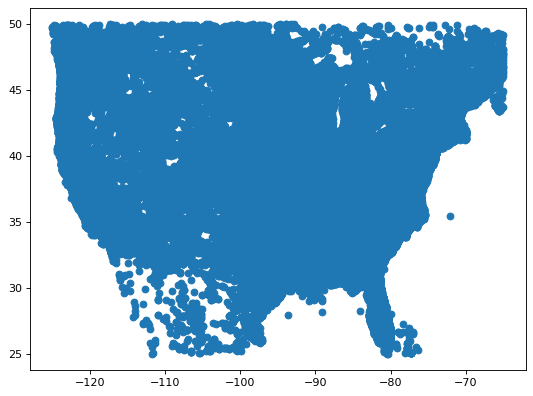

In [147]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(us_data.Longtitude,us_data.Latitude)